# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [20]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.1.0'

#### Load Image Data

In [21]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.001 # start off with high rate first 0.001 and experiment with reducing it gradually 
DECAY_RATE = 0.9
DECAY_STEPS = 10000

#### Generate Training and Validation Batches

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

C:\Users\User\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [23]:
def init_conv(name):
    return tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", 
                                  activation="relu", name=name)

def init_dropout(name):
    return tf.keras.layers.Dropout(0.25, name=name)

In [24]:
INPUT_SHAPE = (224, 224, 3)
vgg16 = tf.keras.applications.VGG16(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet') 
vgg16.trainable = False

In [25]:
conv1 = init_conv('conv_1')
conv2 = init_conv('conv_2')
flatten = tf.keras.layers.Flatten(name='flatten_1')
denseFeature = tf.keras.layers.Dense(256, activation='relu',name='dense_feature')
dropout1 = init_dropout('dropout_1')
dropout2 = init_dropout('dropout_2')
denseOutput = tf.keras.layers.Dense(1, name = 'dense_output',activation='sigmoid')

In [26]:
myModel = tf.keras.Sequential([vgg16, conv1, conv2, flatten, dropout1, 
                             denseFeature,dropout2,denseOutput])
myModel.build(input_shape=INPUT_SHAPE)
myModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv_1 (Conv2D)              (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv_2 (Conv2D)              (None, 7, 7, 256)         590080    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12544)             0         
_________________________________________________________________
dense_feature (Dense)        (None, 256)               3211520   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

#### [5 points] Train Model

In [27]:
learning_rate_sch = tf.keras.optimizers.schedules.ExponentialDecay(decay_rate=DECAY_RATE,
                                                          initial_learning_rate=LEARNING_RATE,
                                                          decay_steps=DECAY_STEPS)
# compile model
Adam = tf.keras.optimizers.Adam()
myModel.compile(loss='binary_crossentropy',
              optimizer=Adam,
              metrics=['accuracy'])

In [28]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

11
3


In [29]:
fit_history = myModel.fit_generator(epochs=NUM_EPOCHS,
                                  generator=train_batches,  
                                  validation_data=valid_batches,
                                  steps_per_epoch=STEP_SIZE_TRAIN, 
                                  validation_steps=STEP_SIZE_VALID)

C:\Users\User\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 2 steps
Epoch 1/40


C:\Users\User\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/10 [==============================] - 58s 6s/step - loss: 1.2195 - accuracy: 0.4300 - val_loss: 0.6642 - val_accuracy: 0.4500
Epoch 2/40
10/10 [==============================] - 49s 5s/step - loss: 0.6081 - accuracy: 0.7234 - val_loss: 0.4877 - val_accuracy: 0.6500
Epoch 3/40
10/10 [==============================] - 47s 5s/step - loss: 0.5529 - accuracy: 0.7447 - val_loss: 0.2926 - val_accuracy: 0.8500
Epoch 4/40
10/10 [==============================] - 51s 5s/step - loss: 0.5452 - accuracy: 0.7234 - val_loss: 0.2962 - val_accuracy: 1.0000
Epoch 5/40
10/10 [==============================] - 45s 5s/step - loss: 0.3957 - accuracy: 0.8830 - val_loss: 0.2635 - val_accuracy: 0.9000
Epoch 6/40
10/10 [==============================] - 45s 4s/step - loss: 0.3253 - accuracy: 0.8830 - val_loss: 0.1129 - val_accuracy: 1.0000
Epoch 7/40
10/10 [==============================] - 46s 5s/step - loss: 0.2741 - accuracy: 0.8830 - val_loss: 0.2207 - val_accuracy: 0.9500
Epoch 8/40
10/10 [=============

#### [5 points] Plot Accuracy and Loss During Training

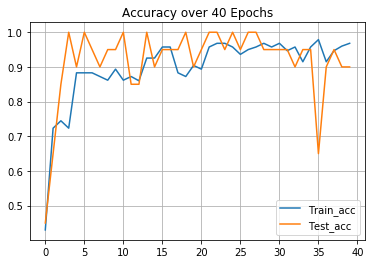

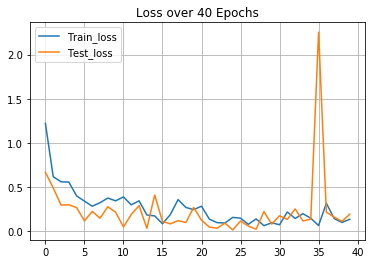

In [40]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history['accuracy'], label='Train_acc')
plt.plot(fit_history.history['val_accuracy'], label = 'Test_acc')
plt.title('Accuracy over {num} Epochs'.format(num=NUM_EPOCHS))
plt.grid(True)
plt.legend(loc='best')
plt.show()

plt.plot(fit_history.history['loss'], label='Train_loss')
plt.plot(fit_history.history['val_loss'], label = 'Test_loss')
plt.title('Loss over {num} Epochs'.format(num=NUM_EPOCHS))
plt.grid(True)
plt.legend(loc='best')
plt.show()

#### Plot Test Results

Found 18 images belonging to 2 classes.
18/18 [==============================] - 8s 428ms/step
covid\nejmoa2001191_f3-PA.jpeg


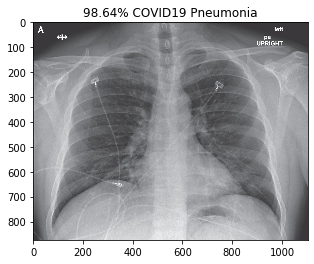

covid\nejmoa2001191_f4.jpeg


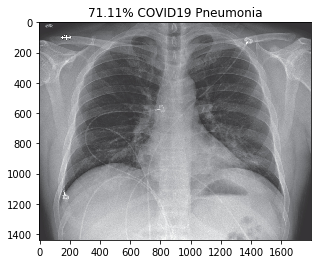

covid\nejmoa2001191_f5-PA.jpeg


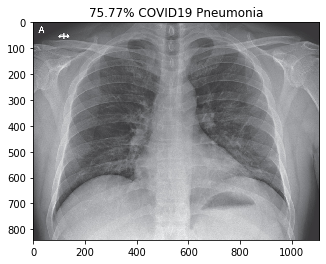

covid\radiol.2020200490.fig3.jpeg


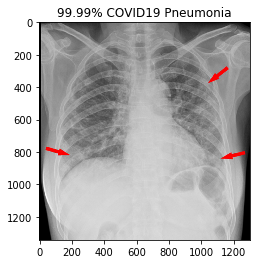

covid\ryct.2020200028.fig1a.jpeg


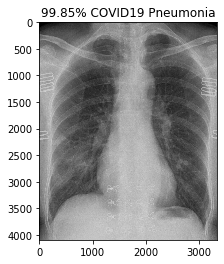

covid\ryct.2020200034.fig2.jpeg


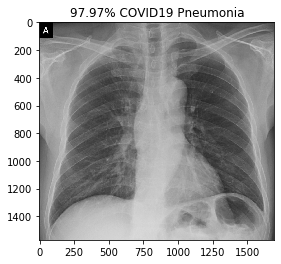

covid\ryct.2020200034.fig5-day0.jpeg


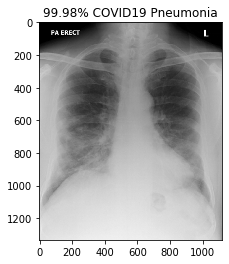

covid\ryct.2020200034.fig5-day4.jpeg


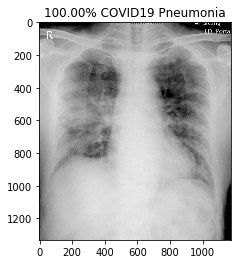

covid\ryct.2020200034.fig5-day7.jpeg


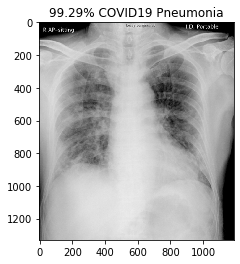

normal\NORMAL2-IM-1385-0001.jpeg


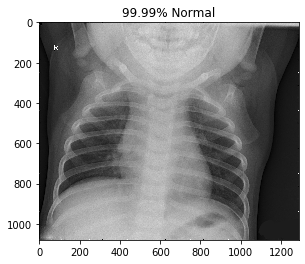

normal\NORMAL2-IM-1396-0001.jpeg


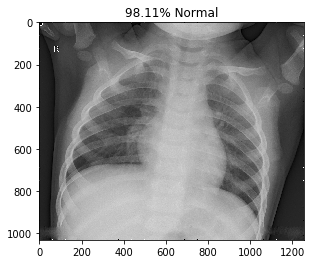

normal\NORMAL2-IM-1400-0001.jpeg


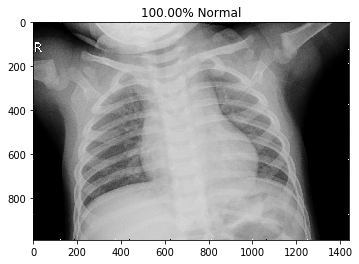

normal\NORMAL2-IM-1401-0001.jpeg


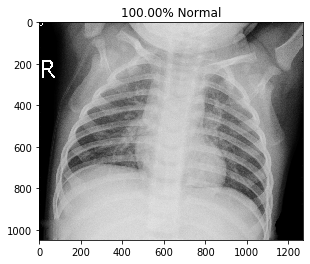

normal\NORMAL2-IM-1406-0001.jpeg


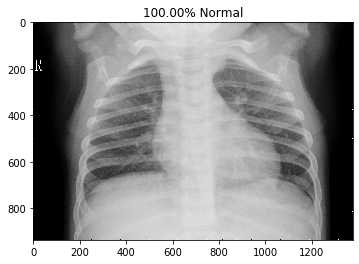

normal\NORMAL2-IM-1412-0001.jpeg


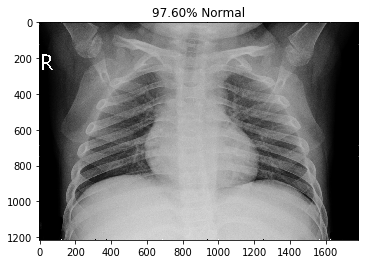

normal\NORMAL2-IM-1419-0001.jpeg


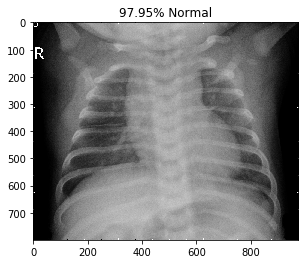

normal\NORMAL2-IM-1422-0001.jpeg


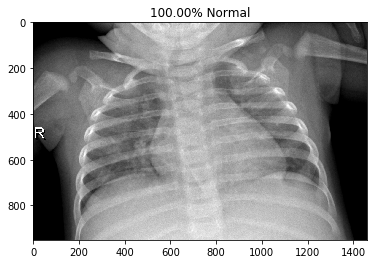

normal\NORMAL2-IM-1423-0001.jpeg


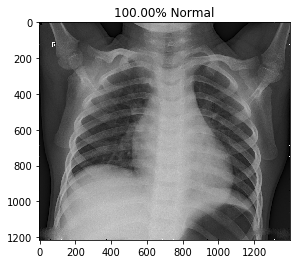

In [31]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,class_mode="binary")
eval_generator.reset()
pred = myModel.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [32]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=myModel.input,
                                        outputs=myModel.get_layer('dense_feature').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

Found 130 images belonging to 2 classes.


In [34]:
# found help here https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
predict = intermediate_layer_model.predict_generator(tsne_eval_generator)
tsne = TSNE(verbose=1, init='pca').fit_transform(predict)

x = tsne[:,0]
y = tsne[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 130 samples in 0.003s...
[t-SNE] Computed neighbors for 130 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 130 / 130
[t-SNE] Mean sigma: 7.231389
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.701626
[t-SNE] KL divergence after 850 iterations: 0.082733


In [35]:
labels = tsne_eval_generator.labels
set_place = {0: [], 1: []}
for i in range(len(x)):
#     print(labels[i])
    set_place[labels[i]].append(i)
# print(set_place)

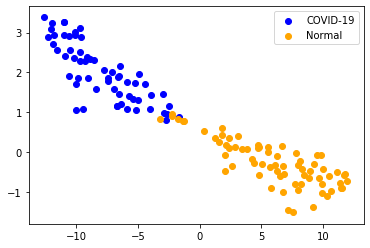

In [37]:
zero_x = np.take(x, set_place[0])
zero_y = np.take(y, set_place[0])

one_x = np.take(x, set_place[1])
one_y = np.take(y, set_place[1])

plt.scatter(zero_x, zero_y, label='COVID-19', color='blue', marker='o')
plt.scatter(one_x, one_y, label='Normal', color='orange', marker='o')
plt.legend(loc='best')
plt.show()
